### Set up Data and Import Libraries

In [177]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
sns.set(style="darkgrid")

In [178]:
#Define df as our Dataset and set date as our index for the Dataset
df = pd.read_csv("data_clean_with_dummies.csv")
df = df.drop(["Unnamed: 0"], axis = 1)
#Define X and y, with X holding the Features and y the correspoding Count of pedestrians
#Features with PCA k=0.99 (PC1 - PC48)
X = df[df.columns[57:103]]

# The targetvariable we try to predict is the pedestrian count
y = df["pedestrians count"]


In [179]:
from sklearn.model_selection import train_test_split

# Split the dataset into train and test sets as numpy arryas (for the Neural Network)
Xtrain, Xtest, ytrain, ytest = train_test_split(
    X, y, test_size=0.3, random_state=72)

### Visualize and exploratory data analysis Data 

In [180]:
df_v = pd.read_csv("data_clean_WITHOUT_dummies.csv") #Load the Dataset without Dummie variables for better visualization
df_v = df_v.drop(labels=range(0,144), axis=0) #Drop the first 144 rows to start with a monday and have better Visualization. The 144 Rows dont matter since we have over 15000
df_v = df_v.set_index('date') #Set the date as the index 

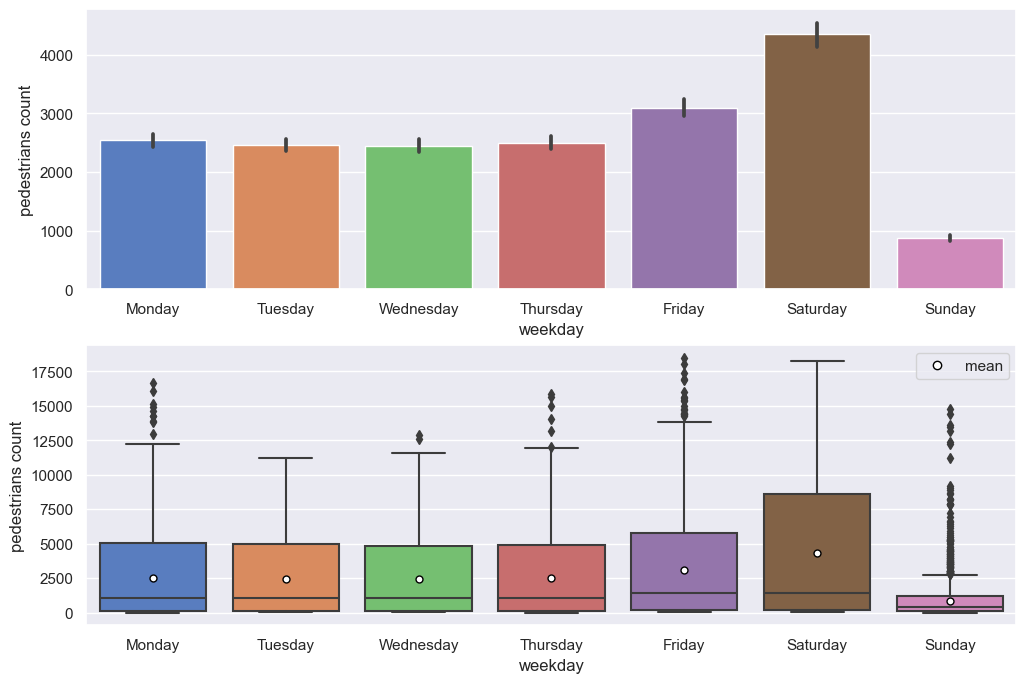

In [181]:
fig, axs = plt.subplots(2, figsize=(12, 8))
sns.barplot(data=df_v, y="pedestrians count", x="weekday", palette="muted", ax=axs[0])
sns.boxplot(data=df_v, y="pedestrians count", x="weekday", palette="muted", ax=axs[1], showmeans=True,  
    meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black","markersize":"5"})

axs[1].legend(handles=[(plt.Line2D([], [], marker="o", color="white", markeredgecolor="black", linewidth=0, label="mean"))])

plt.show()

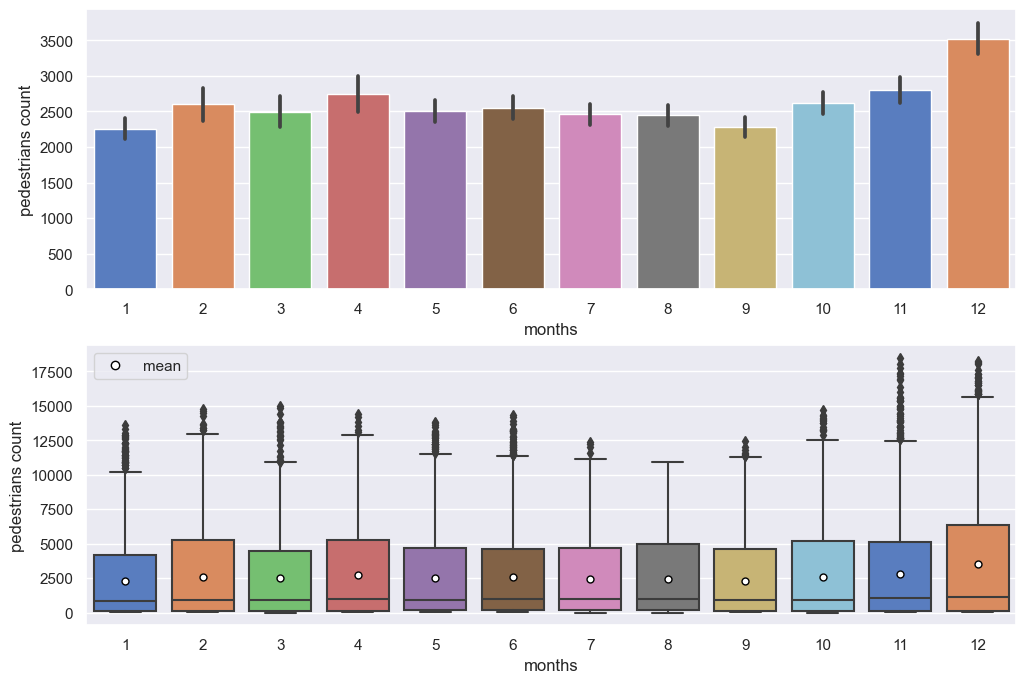

In [182]:
fig, axs = plt.subplots(2, figsize=(12, 8))
sns.barplot(data=df_v, y="pedestrians count", x="months", palette="muted", ax=axs[0])
sns.boxplot(data=df_v, y="pedestrians count", x="months", palette="muted", ax=axs[1], showmeans=True, 
    meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black","markersize":"5"})

axs[1].legend(handles=[(plt.Line2D([], [], marker="o", color="white", markeredgecolor="black", linewidth=0, label="mean"))])

plt.show()

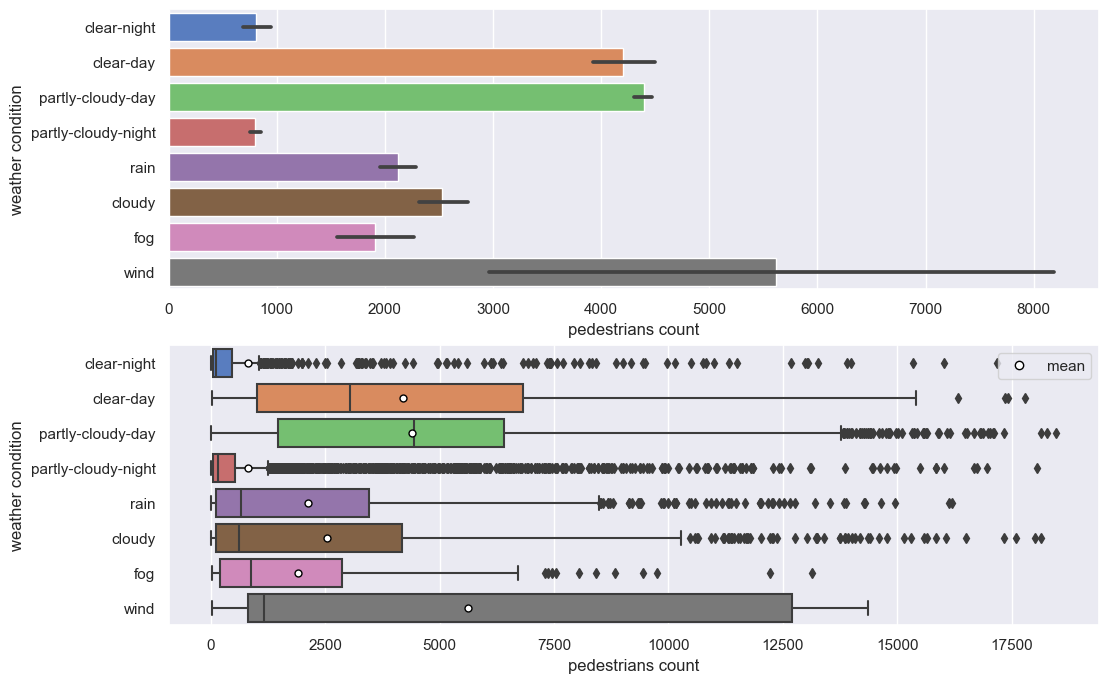

In [183]:
fig, axs = plt.subplots(2, figsize=(12, 8))
sns.barplot(data=df_v, x="pedestrians count", y="weather condition", palette="muted", ax=axs[0]) #Plots Mean
sns.boxplot(data=df_v, x="pedestrians count", y="weather condition", palette="muted", ax=axs[1], showmeans=True,
    meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black","markersize":"5"}) 

axs[1].legend(handles=[(plt.Line2D([], [], marker="o", color="white", markeredgecolor="black", linewidth=0, label="mean"))])    

plt.show()

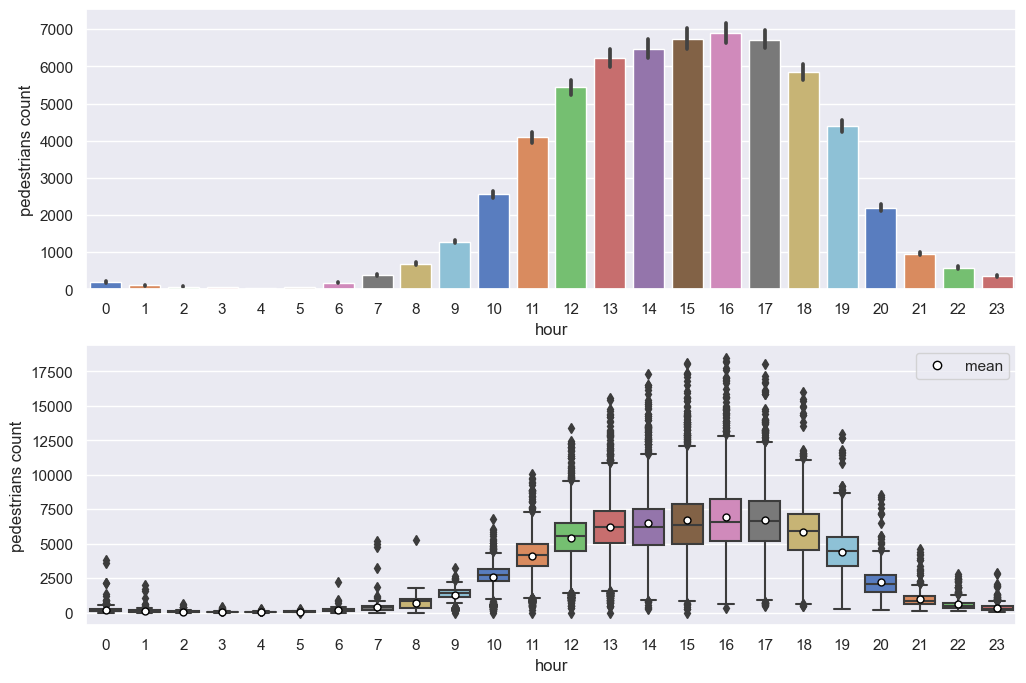

In [184]:
fig, axs = plt.subplots(2, figsize=(12, 8))
sns.barplot(data=df_v, x="hour", y="pedestrians count", palette="muted", ax=axs[0])#Plots Mean
sns.boxplot(data=df_v, x="hour", y="pedestrians count", palette="muted", ax=axs[1], showmeans=True,
    meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black","markersize":"5"})

axs[1].legend(handles=[(plt.Line2D([], [], marker="o", color="white", markeredgecolor="black", linewidth=0, label="mean"))])   

plt.show()

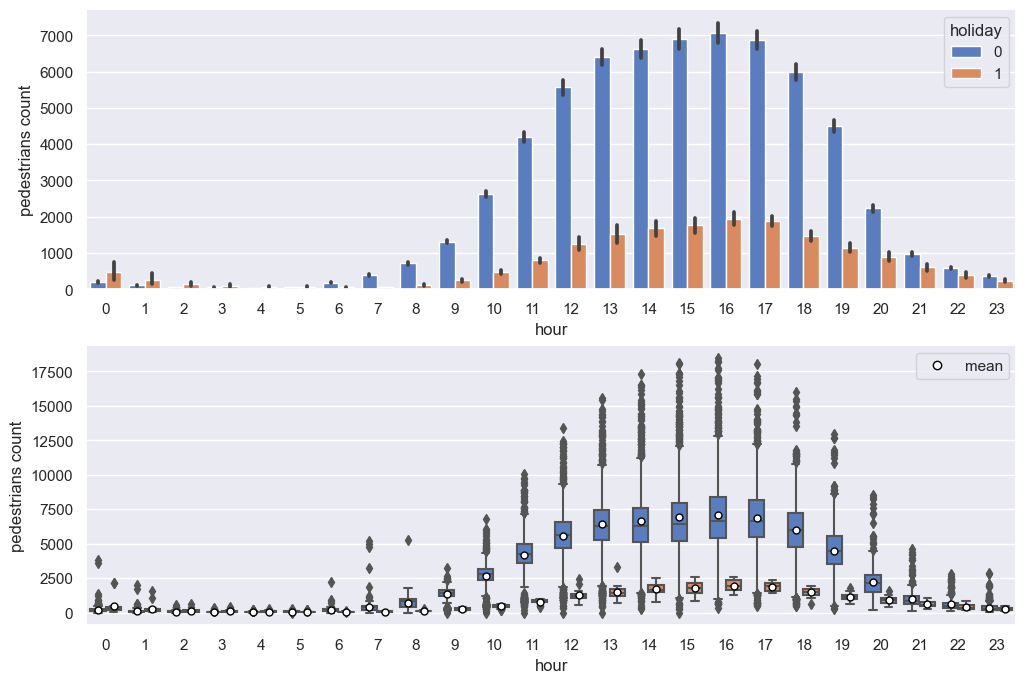

In [185]:
fig, axs = plt.subplots(2, figsize=(12,8))


sns.barplot(data=df_v, x="hour", y="pedestrians count", palette="muted", hue="holiday", ax=axs[0])
sns.boxplot(data=df_v, x="hour", y="pedestrians count", palette="muted", hue="holiday", ax=axs[1], showmeans=True,
    meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black","markersize":"5"})

axs[1].legend(handles=[(plt.Line2D([], [], marker="o", color="white", markeredgecolor="black", linewidth=0, label="mean"))])

plt.show()

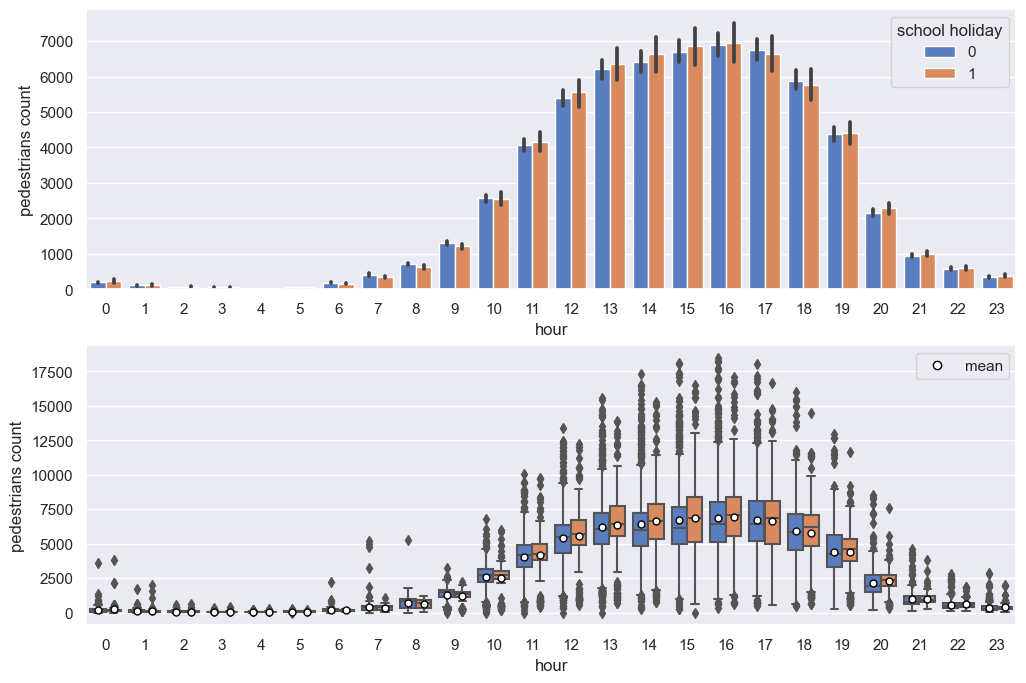

In [186]:
fig, axs = plt.subplots(2, figsize=(12,8))


sns.barplot(data=df_v, x="hour", y="pedestrians count", palette="muted", hue="school holiday", ax=axs[0])
sns.boxplot(data=df_v, x="hour", y="pedestrians count", palette="muted", hue="school holiday", ax=axs[1], showmeans=True,
    meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black","markersize":"5"})

axs[1].legend(handles=[(plt.Line2D([], [], marker="o", color="white", markeredgecolor="black", linewidth=0, label="mean"))])

plt.show()

### Define Functions for easier use

In [187]:
def Xtest_smaller(Xtest, ytest, percent=0.5, min_ped=0):
    """
    Give a certain percent or minimum pedestrian condition on the entries in the Test dataset (or the train dataset) 
    to create a smaller Test dataset to do further exploratorive data analysis.

    percent: Percent of the original Dataset you want to keep on a scale between 0 and 1
    min_pred: Minimum number of pedestrians and the corresponding feautes the smaller dataset should keep

    Check to validate it works:
    1:
    Xtest_small, ytest_small = Xtest_smaller(Xtest, ytest, percent=1, min_ped=0)
    np.array_equal(ytest, ytest_small) --> True

    2:
    Xtest_small, ytest_small = Xtest_smaller(Xtest, ytest, percent=0.5, min_ped=0)
    ytest.shape[0] == ytest_small.shape[0] * 2 --> True

    3:
    Xtest_small, ytest_small = Xtest_smaller(Xtest, ytest, percent=1, min_ped=400)
    ytest_small.min() --> 400
    """

    dfXtest = pd.DataFrame(Xtest) #Create a dataframe
    dfytest = pd.DataFrame(ytest) #Create a dataframe 
    
    dfytest.index = range(dfytest.shape[0]) #set the index of the ytest dataframe to numbers from 0 to len of the dataframe 

    new_df = pd.concat([dfytest, dfXtest], axis=1) #Concat the two dataframes to create a new combined one

    if min_ped > 0: #Check if you want to restrict to a minimum number of pedestrians
        if percent == 1: #Check if you want a 100% of the entries with the minimum number of pedestrians 
            new_df_small = new_df.loc[new_df["pedestrians count"] >= min_ped]

            ytest_small = new_df_small["pedestrians count"]
            Xtest_small = new_df_small[new_df_small.columns[1:49]]
        if percent != 1: #Check if you don't want a 100% of the entries
            new_df_small = new_df.loc[new_df["pedestrians count"] >= min_ped]

            df_ytest_small = new_df_small["pedestrians count"]
            df_Xtest_small = new_df_small[new_df_small.columns[1:49]]

            #Split the dataset into two parts with the test_size determined by the percent of entries you want to keep
            Xtrain_small, Xtest_small, ytrain_small, ytest_small  = train_test_split( 
                df_Xtest_small, df_ytest_small, test_size=percent, random_state=72)
    else: #If you only want to split the original dataset into a smaller one on a percentage basis (without a minimum number of pedestrians)
        df_ytest_small = new_df["pedestrians count"]
        df_Xtest_small = new_df[new_df.columns[1:49]]
        
        #Split the dataset into two parts with the test_size determined by the percent of entries you want to keep
        Xtrain_small, Xtest_small, ytrain_small, ytest_small  = train_test_split(
            df_Xtest_small, df_ytest_small, test_size=percent, random_state=72)
    
    if percent == 1 and min_ped==0: #If you dont want a smaller dataset (idk, reduce possible mistakes)
       Xtest_small = dfXtest #So to_numpy() works in the return statement
       ytest_small = ytest


    return Xtest_small.to_numpy(), ytest_small #Turn dataframe to numpy array in order to perfom mathematical operations


In [188]:

from tensorflow import keras
#Function two quickly define two callbacks with certain parameters
def def_callbacks(stope_p = 10, reducelr_p=5, reducelr_lr=0.00001): #Use standard values when now argument is give n
    """
    stop_early patience = 10
    reduce_lr patience =5, reducelr learning rate=0.00001)
    """
    stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=stope_p) #Stop early stops the model fit once the Mean average error on the validation data doesn't improve after a certain amout of epochs 
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_mae', factor=0.2, #Reduce the learning rate, by a factor of 0.2, when the Mean average error doesn't improve after a certain amout of epochs 
                              patience=reducelr_p, min_lr=reducelr_lr)
    callbacks_list = [stop_early,reduce_lr]
    return callbacks_list
    

### Baseline Model with Tensorflow

In [189]:
from tensorflow.keras import layers
from tensorflow import keras

In [190]:
#Define Baseline Neural Network model

#Create a Keras Sequential class to hold the different layers of our Neural Network
model = keras.Sequential()

model.add(keras.Input(shape=X.shape[1])) #Add a Input layer and define the Input shape of it (which is the column lenght of the feature Dataset X)
model.add(layers.Dense(100, activation="relu")) #Add a Hidden layer with 100 neurones with Dense. Dense takes the output from our Input layer applies a weight matrix and than applies a activation function (in this case relu).
model.add(layers.Dense(50, activation="relu")) #Add a second Hidden layer with 50 Neurones with Dense. Dense takes the output from our first hidden layer applies a weight matrix and than applies a activation function (in this case relu).
model.add(layers.Dense(50, activation="relu")) #Add a third Hidden layer with 50 neurones with Dense. 
model.add(layers.Dense(50, activation="relu")) #Add a third Hidden layer with 50 neurones with Dense. 
model.add(layers.Dense(25, activation="relu")) #Add a fourth Hidden layer with 25 neurones with Dense. 
model.add(layers.Dense(10, activation="relu")) #Add a fourth Hidden layer with 10 neurones with Dense. 
model.add(layers.Dense(10, activation="relu")) #Add a fourth Hidden layer with 10 neurones with Dense. 
model.add(layers.Dense(1, activation="relu")) # Add a output layer with 1 Neuron because we only have one output --> predicted pedestrian count

model.summary()#Display an overview of the model 


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_23 (Dense)            (None, 100)               4700      
                                                                 
 dense_24 (Dense)            (None, 50)                5050      
                                                                 
 dense_25 (Dense)            (None, 50)                2550      
                                                                 
 dense_26 (Dense)            (None, 50)                2550      
                                                                 
 dense_27 (Dense)            (None, 25)                1275      
                                                                 
 dense_28 (Dense)            (None, 10)                260       
                                                                 
 dense_29 (Dense)            (None, 10)               

In [191]:

#Specify the training configuration for the Neural Network
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),  # Optimizer that minimizes our loss function (f.e SGD or Adam) with a learning rate of 0.001
    loss=keras.losses.mae,  # Loss function the Optimizer minimizes --> Mean absolute error 
    metrics=["mae"], # List of metrics to monitor
)


#Fit the model an the training data and use a validation split for ###???Cross validation????#####
history = model.fit(
    Xtrain, # Fit the model on the train data 
    ytrain, #The target variable used to calculate the mean absolut error between the target variable and the predictions of the model 
    #batch_size=64, #Dataset will be divided into batches with 64 samples and will be updated after each batch size accordingly
    epochs=250, # 1 epoch is one training iteration - for each epoch the Neural Network processes the entire training data and updates the weights 
    callbacks = def_callbacks(25), #Stop training when training is no longer improving Mean absolute error of the validation data (20% of the training data) within 20 epochs(--> def_callbacks Function)
    validation_split=0.2, #Reserve 20% of the training data for validation at the end of each epoch, to prevent overfitting
)

Epoch 1/250


/Users/wanja/opt/miniconda3/envs/dsf/lib/python3.10/site-packages/keras/engine/data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]
2022-12-01 15:35:29.338025: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


269/269 [==============================] - ETA: 0s - loss: 1815.6128 - mae: 1815.6128

2022-12-01 15:35:33.037603: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


269/269 [==============================] - 5s 15ms/step - loss: 1815.6128 - mae: 1815.6128 - val_loss: 942.4667 - val_mae: 942.4667 - lr: 0.0010
Epoch 2/250
269/269 [==============================] - 4s 13ms/step - loss: 834.5999 - mae: 834.5999 - val_loss: 724.5818 - val_mae: 724.5818 - lr: 0.0010
Epoch 3/250
269/269 [==============================] - 3s 13ms/step - loss: 656.3291 - mae: 656.3291 - val_loss: 577.6814 - val_mae: 577.6814 - lr: 0.0010
Epoch 4/250
269/269 [==============================] - 3s 11ms/step - loss: 542.2877 - mae: 542.2877 - val_loss: 498.9083 - val_mae: 498.9083 - lr: 0.0010
Epoch 5/250
269/269 [==============================] - 3s 12ms/step - loss: 471.2630 - mae: 471.2630 - val_loss: 443.2139 - val_mae: 443.2139 - lr: 0.0010
Epoch 6/250
269/269 [==============================] - 3s 11ms/step - loss: 413.9501 - mae: 413.9501 - val_loss: 452.9521 - val_mae: 452.9521 - lr: 0.0010
Epoch 7/250
269/269 [==============================] - 3s 12ms/step - loss: 383.

### Model evaluation

In [192]:
# Evaluate the model on the test data using `evaluate` result is the corresponding loss functin (MAE), MAE and MSE (Metrics defined the model configuration)
print("Evaluation on the Test data")
results = model.evaluate(Xtest, ytest)
results_train = model.evaluate(Xtrain, ytrain)
print("Test data loss(MAE), Test data MAE, Test data MSE:", results)
print("Train data loss(MAE), Train data MAE, Train data MSE:", results_train)

Evaluation on the Test data
336/336 [==============================] - 2s 6ms/step - loss: 244.6261 - mae: 244.6261
Test data loss(MAE), Test data MAE, Test data MSE: [301.5697937011719, 301.5697937011719]
Train data loss(MAE), Train data MAE, Train data MSE: [244.6260528564453, 244.6260528564453]


In [193]:
#Create a function that evaluates the model and saves the results in a dataframe for comparisson with the Hypertuned models
def evaluate_model(model, Xtest, ytest): #Evaluate the Model on the Test data
    eval_dict = model.evaluate(Xtest, ytest, return_dict=True) #Create a dictionary to stoe the results 
    
    display_df = pd.DataFrame([eval_dict.values()], columns=[list(eval_dict.keys())]) #Create a dataframe out of the dictionary 
    
    return display_df

# Evaluate basemodel on Test Data with the above created function
results_comparisson = evaluate_model(model, Xtest, ytest) 

#Set the index as 'Basemodel
results_comparisson.index = ["Basemodel on test data"]

# Display results
results_comparisson.head()

144/144 [==============================] - 1s 5ms/step - loss: 301.5698 - mae: 301.5698


loss         mae
Basemodel on test data  301.569794  301.569794

### Visualize the Model performance

  1/144 [..............................] - ETA: 28s

2022-12-01 15:39:30.089540: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


144/144 [==============================] - 1s 3ms/step


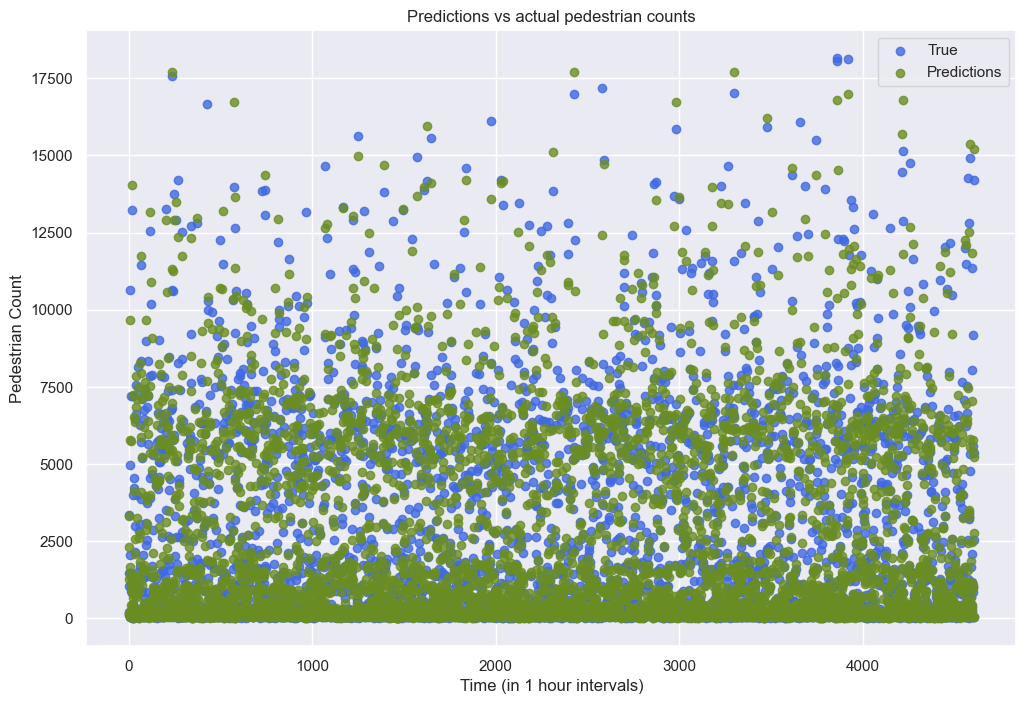

In [194]:
#Visualize the results predictions vs actual pedestrian counts
#Create a sequenze from 0 to the row lenght of the test data in order to plot
xs = np.linspace(0, ytest.shape[0], num=ytest.shape[0])

#Using the Neural Network to predict the Pedestrian count for our Xtest set in order to plot it against the actual pedestrian count
ypred = model.predict(Xtest)


fig, axs = plt.subplots(figsize=(12, 8))

axs.scatter(xs, ytest, color ='royalblue', alpha=0.8, label="True") #Plot the actual pedestrian count 
axs.scatter(xs, ypred, color ='olivedrab', alpha=0.8, label="Predictions") #Plot the predicted pedestrian count 
axs.set_title('Predictions vs actual pedestrian counts')
axs.set_ylabel('Pedestrian Count')
axs.set_xlabel('Time (in 1 hour intervals)')
axs.legend(loc='upper right')

144/144 [==============================] - 1s 5ms/step - loss: 301.5698 - mae: 301.5698


Text(109.87499999999999, 0.5, 'MAE')

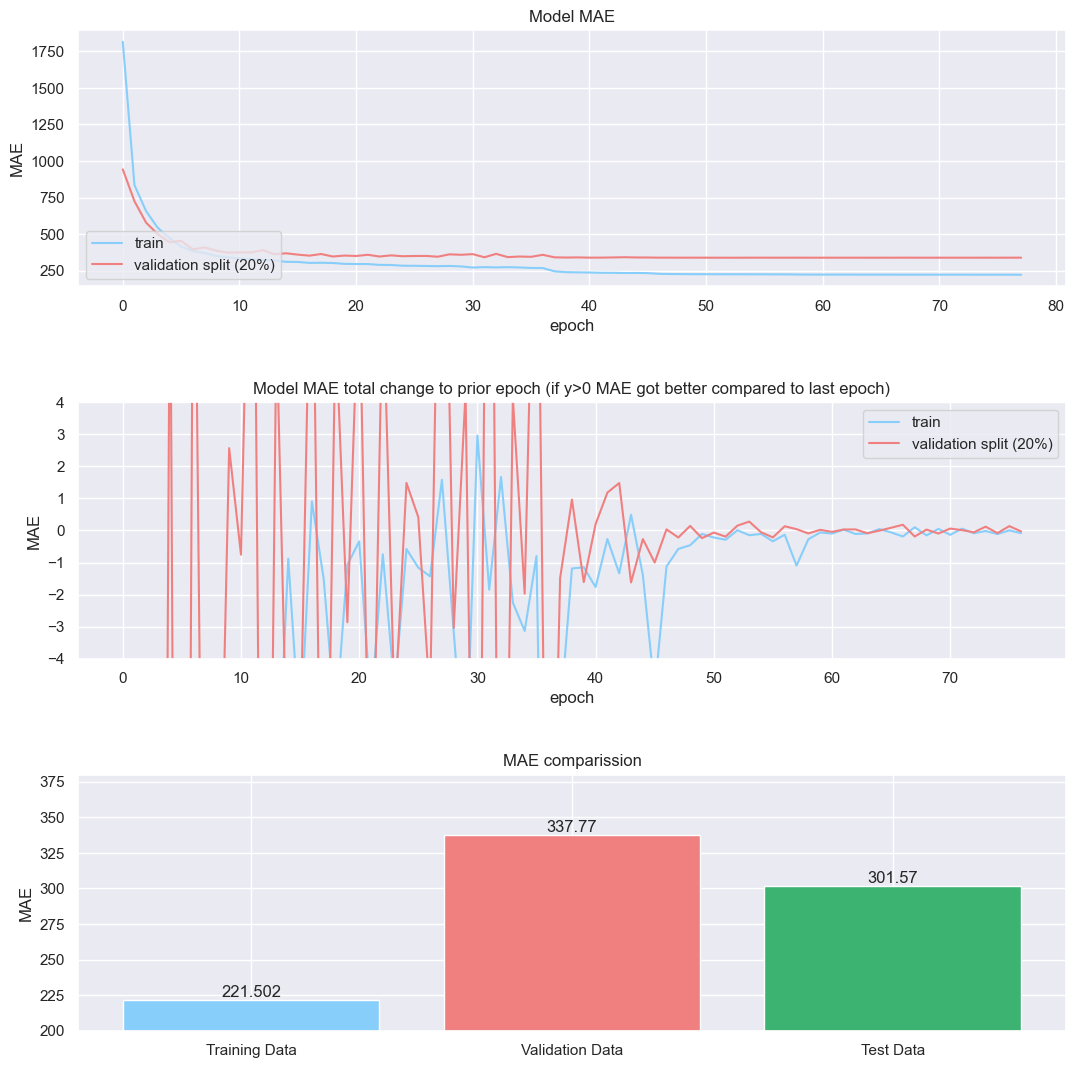

In [195]:
#Plot the MAE on the training data against the validation split of the Training data over time 
#history.history.keys()

fig, axs = plt.subplots(3, figsize=(12, 12))

fig.tight_layout(pad=5.0)

axs[0].plot(history.history['mae'], label="train", color="lightskyblue")
axs[0].plot(history.history['val_mae'], label="validation split (20%)", color="lightcoral")
axs[0].set_title('Model MAE')
axs[0].set_ylabel('MAE')
axs[0].set_xlabel('epoch')
axs[0].legend(loc='lower left')


len_epoch = len(history.history["mae"]) #How many total epochs
#Compare the MAE of the Test Data with the one in the prior epoch and take the difference to see if it got better 
dif_train = [history.history["mae"][1+l] - history.history["mae"][0+l] for l in range(len_epoch-1)] 
#Compare the MAE of the Validation Data with the one in the prior epoch and take the difference to see if it got better 
dif_val = [history.history["val_mae"][1+l] - history.history["val_mae"][0+l] for l in range(len_epoch-1)] 

axs[1].plot(dif_train, label="train", color="lightskyblue")
axs[1].plot(dif_val, label="validation split (20%)", color="lightcoral")
axs[1].set_title('Model MAE total change to prior epoch (if y>0 MAE got better compared to last epoch)')
axs[1].set_ylabel('MAE')
axs[1].set_xlabel('epoch')
axs[1].legend(loc='upper right')
axs[1].set_ylim([-4, 4])

f_mae = history.history["mae"]
f_val_mae = history.history["val_mae"]
f_test_mae = model.evaluate(Xtest, ytest)

axs[2].bar("Training Data",min(f_mae), color="lightskyblue") #Display minimum mae of the training data set
axs[2].bar("Validation Data", min(f_val_mae), color="lightcoral")#Display minimum mae of the validation data set
axs[2].bar("Test Data", f_test_mae[0], color="mediumseagreen")#Display mae of the test data set
axs[2].bar_label(axs[2].containers[0], label_type='edge')
axs[2].bar_label(axs[2].containers[1], label_type='edge')
axs[2].bar_label(axs[2].containers[2], label_type='edge')
axs[2].set_ylim([200, 380])
axs[2].set_title('MAE comparission')
axs[2].set_ylabel('MAE')


### Hyperparamter tuning 

In [196]:
import keras_tuner as kt

#### Tuning Optimzer, learning rate and activation function (Hyperparameter)
##### This approach is used to reduce the computing time. A better way would be to build a larger model where the tuner would tune the optimizer, learning rate, activation function, number of layers and number on nodes etc. at the same time

In [197]:
#Find the best Optimizer, activation fucntion and learning rate for the baseline model 
def h1_model_builder(hp): 
 
#Create a Keras Sequential class to hold the different layers of our Neural Network
    model = keras.Sequential()

    #Tune activation function
    hp_activation = hp.Choice('activation', values=['relu', 'tanh']) #Define a Hyperparameter as a choiche (option) for different activation functions. The tuner will try these to find the best possible for the baseline model 

    model.add(keras.layers.Flatten()) #Add a Input layer and use flatten to get a 1 dimensional input!!!!
    model.add(layers.Dense(100, activation=hp_activation)) #Add a Hidden layer with 100 Neurones with Dense. Dense takes the output from our Input layer applies a weight matrix and than applies a activation function (in this case relu).
    model.add(layers.Dense(50, activation=hp_activation)) #Add a second Hidden layer with 50 Neurones with Dense. Dense takes the output from our first hidden layer applies a weight matrix and than applies a activation function (in this case relu).
    model.add(layers.Dense(50, activation=hp_activation)) #Add a third Hidden layer with 50 Neurones with Dense. 
    model.add(layers.Dense(50, activation=hp_activation)) #Add a third Hidden layer with 50 Neurones with Dense. 
    model.add(layers.Dense(25, activation=hp_activation)) #Add a fourth Hidden layer with 25 Neurones with Dense. 
    model.add(layers.Dense(10, activation=hp_activation)) #Add a fourth Hidden layer with 10 Neurones with Dense. 
    model.add(layers.Dense(10, activation=hp_activation)) #Add a fourth Hidden layer with 10 Neurones with Dense. 
    model.add(layers.Dense(1, activation=hp_activation))  #Add an output layer with activation function relu  

    #Tune learning rate 
    hp_learning_rate = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4, 1e-5])  # Define a Hyperparameter as a choice to tune learning rate with the values 0.01, 0.001, 0.0001, 0.00001

    #Create a dictionary to hold the different optimization functions 
    optimizers_dict = {
        "Adam":    keras.optimizers.Adam(learning_rate=hp_learning_rate),
        "SGD":     keras.optimizers.SGD(learning_rate=hp_learning_rate),
        "Adagrad": keras.optimizers.Adagrad(learning_rate=hp_learning_rate),
        "Adadelta": keras.optimizers.Adadelta(learning_rate=hp_learning_rate),
        "RMSprop": keras.optimizers.RMSprop(learning_rate=hp_learning_rate)
        }

    hp_optimizers = hp.Choice( #Define a Hyperparameter as a choice to tune the optimizer 
        'optimizer', values=["Adam", "SGD", "Adagrad", "Adadelta", "RMSprop"] #Options the tuner will try, that correspond to the optimizer dictionary keys 
        )


    model.compile(optimizer=optimizers_dict[hp_optimizers], #Complie the model and use the optimizer choice as input for the optimizer 
                  loss=keras.losses.mae, #Loss function is Mean average error 
                  metrics=["mae"])
    
    return model

In [198]:
#Easy tuner because we only have 5 different Optimizer options, 4 learning rate optimizations and 2 activation functions, 
# so randomly selecting is okay because no matter what we will try every combination of the 40
h1_tuner = kt.RandomSearch(hypermodel = h1_model_builder, #The model the Randomsearch tuner will tune 
                       objective = 'val_mae', #Objetive the tuner will try to minimize 
                       max_trials =45 , #The total number of trails to test at most (to try every combination it has to be at least 40 (5*4*2))
                       directory = 'kt_dir', #create a dictionary to store the tries and metrics 
                       overwrite=True, #To be able to overwrite prior tuner entries
                       project_name = 'kt_RandomSearch')

In [199]:
#Initiate the tuner with the Train data
#Tune for 10 epochs with a validation split of 20% and a possible minimum learning rate of 0.000001 for 
# the Reduce learning rate callback function
h1_tuner.search(Xtrain, ytrain, epochs=20, validation_split=0.2, callbacks=def_callbacks(reducelr_lr=0.00001)) 

Trial 30 Complete [00h 01m 17s]
val_mae: 672.2263793945312

Best val_mae So Far: 337.9484558105469
Total elapsed time: 02h 48m 58s
INFO:tensorflow:Oracle triggered exit


In [200]:
#Create a new Model with the Hyperparameters found by the tuner
h1_best_hps = h1_tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The first hyperparameter search is complete. The best optimizer is {h1_best_hps.get('optimizer')}, the best activation function is 
{h1_best_hps.get("activation")} and the optimal learning rate for the optimizer is {h1_best_hps.get('learning_rate')}.
Summary:
""")

#Display the best 10 Hypermodel configurations found by the tuner
h1_tuner.results_summary() 

#Hypertuned Model 
h1_model = h1_tuner.hypermodel.build(h1_best_hps)
#Create a new History for the model to compare it with the Baseline Histroy 
h1_history = h1_model.fit(Xtrain, ytrain, epochs=150, validation_split=0.2,
                    callbacks=def_callbacks(reducelr_lr=0.000001))


The first hyperparameter search is complete. The best optimizer is RMSprop, the best activation function is 
relu and the optimal learning rate for the optimizer is 0.01.
Summary:

Results summary
Results in kt_dir/kt_RandomSearch
Showing 10 best trials
Trial summary
Hyperparameters:
activation: relu
learning_rate: 0.01
optimizer: RMSprop
Score: 337.9484558105469
Trial summary
Hyperparameters:
activation: relu
learning_rate: 0.001
optimizer: Adam
Score: 354.8769226074219
Trial summary
Hyperparameters:
activation: relu
learning_rate: 0.001
optimizer: RMSprop
Score: 365.5799255371094
Trial summary
Hyperparameters:
activation: relu
learning_rate: 0.01
optimizer: Adadelta
Score: 457.39910888671875
Trial summary
Hyperparameters:
activation: relu
learning_rate: 0.0001
optimizer: Adam
Score: 672.2263793945312
Trial summary
Hyperparameters:
activation: relu
learning_rate: 0.0001
optimizer: RMSprop
Score: 742.9833984375
Trial summary
Hyperparameters:
activation: relu
learning_rate: 0.001
optim

/Users/wanja/opt/miniconda3/envs/dsf/lib/python3.10/site-packages/keras/engine/data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]
2022-12-01 18:29:26.839962: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


269/269 [==============================] - ETA: 0s - loss: 990.4166 - mae: 990.4166

2022-12-01 18:29:36.623982: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


269/269 [==============================] - 12s 26ms/step - loss: 990.4166 - mae: 990.4166 - val_loss: 640.6396 - val_mae: 640.6396 - lr: 0.0100
Epoch 2/150
269/269 [==============================] - 6s 20ms/step - loss: 668.9415 - mae: 668.9415 - val_loss: 658.7423 - val_mae: 658.7423 - lr: 0.0100
Epoch 3/150
269/269 [==============================] - 5s 18ms/step - loss: 590.9059 - mae: 590.9059 - val_loss: 678.0661 - val_mae: 678.0661 - lr: 0.0100
Epoch 4/150
269/269 [==============================] - 5s 17ms/step - loss: 538.7401 - mae: 538.7401 - val_loss: 465.1427 - val_mae: 465.1427 - lr: 0.0100
Epoch 5/150
269/269 [==============================] - 5s 18ms/step - loss: 516.1889 - mae: 516.1889 - val_loss: 488.3424 - val_mae: 488.3424 - lr: 0.0100
Epoch 6/150
269/269 [==============================] - 5s 18ms/step - loss: 493.6400 - mae: 493.6400 - val_loss: 472.6296 - val_mae: 472.6296 - lr: 0.0100
Epoch 7/150
269/269 [==============================] - 5s 17ms/step - loss: 464.7

In [201]:
# Evaluate model on test set using the above created function to save the results in the results_comparisson dataframe
hyper_results1 = evaluate_model(h1_model, Xtest, ytest) 

# Set index to Baseline model Op/lr/af
hyper_results1.index = ["First Hypertuned model on test data"]

# Append results in dataframe
results_comparisson = pd.concat([results_comparisson, hyper_results1])

results_comparisson.head()


144/144 [==============================] - 2s 15ms/step - loss: 298.2711 - mae: 298.2711


loss         mae
Basemodel on test data               301.569794  301.569794
First Hypertuned model on test data  298.271118  298.271118

#### Optimal number of layers and nodes
#### Find the optimal number of layers and nodes and if Dropout is benefitial or not.

In [202]:
def h2_model_builder(hp): 
 
    #Create a Keras Sequential class to hold the different layers of our Neural Network
    model = keras.Sequential()
    model.add(keras.layers.Flatten())
    
# Tune the number of hidden layers and units (Nodes)
    # Number of hidden layers: 8 - 12
    for i in range(hp.Int("num_layers", 6, 8)):
        
        # Number of Nodes: 32 - 512 with stepsize of 32
        model.add(
            keras.layers.Dense(
                units=hp.Int("units_" + str(i), min_value=32, max_value=128, step=32), #Define a Hyperparameter as a integer between 32 and 128 as different amount of Nodes 
                activation="relu") #Using the best activation function found by the tuner above for the baseline model (Giving a choice and tuning it again would be likely better but much more time consuing to compute)
            )
        
    if hp.Boolean("dropout"): #Define a Hyperparameter as a Boolean value to either use or not use Dropout
        #Will randomly "droput" (deactivate) different weights (25% of total) and train the model on the remaining. After the tuning is done all weights will be keept (so no weights are actualy not used by the final mdoel)
        model.add(layers.Dropout(rate=0.25)) 
    
    
    # Add output layer
    model.add(keras.layers.Dense(units=1, activation="relu"))
    
    #Here setting a learning rate (best by above tuner on baseline model) is better/more efficient because other wise the Tuner would also have to tune the learning rate adding a huge amout of new models to try 
    # Define optimizer, loss, and metrics
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
                  loss=keras.losses.mae,
                  metrics=["mae"])
    
    return model

In [203]:
# Using the Hyperband tuner which selects different Hyperparameter combinations when the have promising results after a few epochs and tunes them further
h2_tuner = kt.Hyperband(hypermodel=h2_model_builder, #Select the model that should be tuned
                     objective='val_mae', #Objective to minimize, in this case the validation split Mean average error
                     max_epochs=25, #Maximum number of epochs to train 1 model configuration 
                     hyperband_iterations=2, #the number of times to iterate over the full Hyperband algorithm
                     overwrite=True, ##To be able to overwrite prior tuner entries
                     directory='kt_dir',
                     project_name='kt_Hyperband')


In [204]:
# Execute the tuner  
h2_tuner.search(Xtrain, ytrain, epochs=25, validation_split=0.2, callbacks=def_callbacks(reducelr_lr=0.000001, reducelr_p=3))

Trial 60 Complete [00h 01m 14s]
val_mae: 335.6121826171875

Best val_mae So Far: 316.39788818359375
Total elapsed time: 01h 33m 32s
INFO:tensorflow:Oracle triggered exit


In [205]:
#Use the best Hyperparameter to build a new model and train the model on the training Dataset

#Create a new Model with the Hyperparameters found by the tuner
h2_best_hps = h2_tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The second hyperparameter search is complete. The optimal number of layers is {h2_best_hps.get('num_layers')}.
Summary:
""")

#Display the best 10 Hypermodel configurations found by the tuner
h2_tuner.results_summary()

#Hypertuned Model 
h2_model = h2_tuner.hypermodel.build(h2_best_hps)
#Create a new History for the model to compare it with the other models
h2_history = h2_model.fit(Xtrain, ytrain, epochs=150, validation_split=0.2,
                    callbacks=def_callbacks(reducelr_lr=0.000001))


The second hyperparameter search is complete. The optimal number of layers is 7.
Summary:

Results summary
Results in kt_dir/kt_Hyperband
Showing 10 best trials
Trial summary
Hyperparameters:
num_layers: 7
units_0: 64
units_1: 96
units_2: 96
units_3: 96
units_4: 64
units_5: 128
dropout: True
units_6: 96
units_7: 96
tuner/epochs: 25
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 316.39788818359375
Trial summary
Hyperparameters:
num_layers: 7
units_0: 64
units_1: 96
units_2: 64
units_3: 32
units_4: 96
units_5: 96
dropout: False
units_6: 96
units_7: 96
tuner/epochs: 25
tuner/initial_epoch: 9
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0048
Score: 320.9866943359375
Trial summary
Hyperparameters:
num_layers: 6
units_0: 64
units_1: 128
units_2: 128
units_3: 96
units_4: 32
units_5: 32
dropout: False
units_6: 32
units_7: 128
tuner/epochs: 25
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 322.8867492675781
Trial summary
Hyperparameters:
num_layers: 7
units_0: 

/Users/wanja/opt/miniconda3/envs/dsf/lib/python3.10/site-packages/keras/engine/data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]
2022-12-01 20:09:57.669160: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


269/269 [==============================] - ETA: 0s - loss: 969.4489 - mae: 969.4489

2022-12-01 20:10:02.174395: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


269/269 [==============================] - 6s 17ms/step - loss: 969.4489 - mae: 969.4489 - val_loss: 692.8873 - val_mae: 692.8873 - lr: 0.0100
Epoch 2/150
269/269 [==============================] - 3s 12ms/step - loss: 548.6195 - mae: 548.6195 - val_loss: 469.5633 - val_mae: 469.5633 - lr: 0.0100
Epoch 3/150
269/269 [==============================] - 3s 11ms/step - loss: 477.4987 - mae: 477.4987 - val_loss: 414.7606 - val_mae: 414.7606 - lr: 0.0100
Epoch 4/150
269/269 [==============================] - 3s 11ms/step - loss: 472.8591 - mae: 472.8591 - val_loss: 739.2661 - val_mae: 739.2661 - lr: 0.0100
Epoch 5/150
269/269 [==============================] - 3s 11ms/step - loss: 466.7132 - mae: 466.7132 - val_loss: 418.1963 - val_mae: 418.1963 - lr: 0.0100
Epoch 6/150
269/269 [==============================] - 3s 11ms/step - loss: 432.2393 - mae: 432.2393 - val_loss: 415.8925 - val_mae: 415.8925 - lr: 0.0100
Epoch 7/150
269/269 [==============================] - 3s 11ms/step - loss: 418.23

In [206]:
# Evaluate model on test set using the above created function to save the results in the results_comparisson dataframe
hyper_results2 = evaluate_model(h2_model, Xtest, ytest)

# Set index to hypertuned
hyper_results2.index = ["Second Hypertuned model on test data"]

# Append results in dataframe
results_comparisson = pd.concat([results_comparisson, hyper_results2])

results_comparisson.head()

144/144 [==============================] - 1s 5ms/step - loss: 295.4812 - mae: 295.4812


loss         mae
Basemodel on test data                301.569794  301.569794
First Hypertuned model on test data   298.271118  298.271118
Second Hypertuned model on test data  295.481201  295.481201

### Viusalize the Hypertuned Model 

2022-12-01 20:11:48.115334: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


144/144 [==============================] - 1s 4ms/step


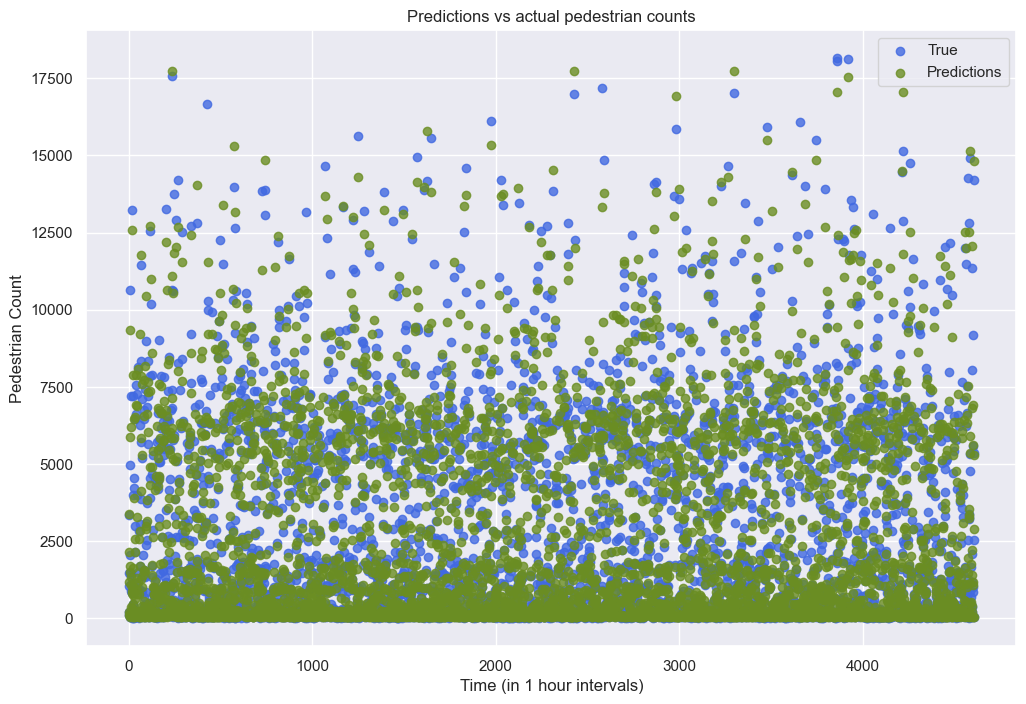

In [207]:
#Visualize the results predictions vs actual values
#Create a sequenze from 0 to the row lenght of the test data in order to plot
xs = np.linspace(0, ytest.shape[0], num=ytest.shape[0])

#Using the Neural Network to predict the Pedestrian count for our Xtest set in order to plot it against the actual values
yhpred = h2_model.predict(Xtest) #Predict the pedestrian count with the final Hypertuned model

fig, axs = plt.subplots(figsize=(12, 8))

axs.scatter(xs, ytest, color ='royalblue', alpha=0.8, label="True")
axs.scatter(xs, yhpred, color ='olivedrab', alpha=0.8, label="Predictions")
axs.set_title('Predictions vs actual pedestrian counts')
axs.set_ylabel('Pedestrian Count')
axs.set_xlabel('Time (in 1 hour intervals)')
axs.legend(loc='upper right')

2022-12-01 20:11:49.597593: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


144/144 [==============================] - 1s 7ms/step - loss: 301.5698 - mae: 301.5698


2022-12-01 20:11:51.104997: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


144/144 [==============================] - 1s 5ms/step - loss: 295.4812 - mae: 295.4812


Text(109.87499999999999, 0.5, 'MAE')

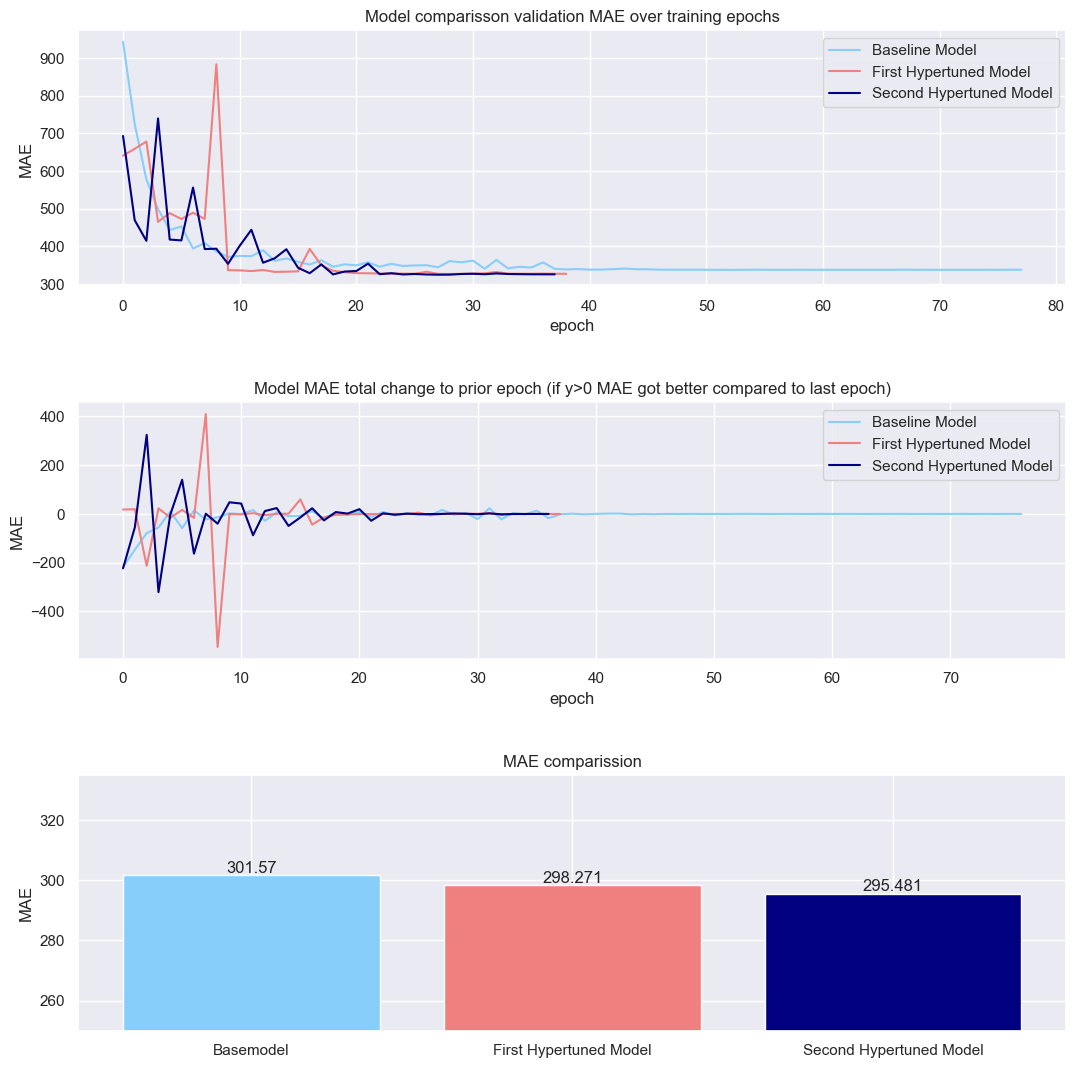

In [208]:
#Plot the MAE on the training data against the validation split of the Training data over time 
#history.history.keys()

fig, axs = plt.subplots(3, figsize=(12, 12))

fig.tight_layout(pad=5.0)

axs[0].plot(history.history['val_mae'], label="Baseline Model", color="lightskyblue")
axs[0].plot(h1_history.history['val_mae'], label="First Hypertuned Model", color="lightcoral")
axs[0].plot(h2_history.history['val_mae'], label="Second Hypertuned Model", color="Navy")
axs[0].set_title('Model comparisson validation MAE over training epochs')
axs[0].set_ylabel('MAE')
axs[0].set_xlabel('epoch')
axs[0].legend(loc='upper right')

len_epoch = len(history.history["mae"]) #How many total epochs with the Baseline Model
h1_len_epoch = len(h1_history.history["mae"]) #How many total epochs with the first Hypertuned Model
h2_len_epoch = len(h2_history.history["mae"]) #How many total epochs with the second Hypertuned Model

#Baseline Model: Compare the MAE of the Validation Data with the one in the prior epoch and take the difference to see if it got better 
dif_val = [history.history["val_mae"][1+l] - history.history["val_mae"][0+l] for l in range(len_epoch-1)] 
#First Hypertuned Model: Compare the MAE of the Validation Data with the one in the prior epoch and take the difference to see if it got better 
h1_dif_val = [h1_history.history["val_mae"][1+l] - h1_history.history["val_mae"][0+l] for l in range(h1_len_epoch-1)] 
#Second Hypertuned Model: Compare the MAE of the Validation Data with the one in the prior epoch and take the difference to see if it got better 
h2_dif_val = [h2_history.history["val_mae"][1+l] - h2_history.history["val_mae"][0+l] for l in range(h2_len_epoch-1)] 


 
axs[1].plot(dif_val, label="Baseline Model", color="lightskyblue")
axs[1].plot(h1_dif_val, label="First Hypertuned Model", color="lightcoral")
axs[1].plot(h2_dif_val, label="Second Hypertuned Model", color="navy")
axs[1].set_title('Model MAE total change to prior epoch (if y>0 MAE got better compared to last epoch)')
axs[1].set_ylabel('MAE')
axs[1].set_xlabel('epoch')
axs[1].legend(loc='upper right')
#axs[1].set_ylim([-15, 15])



base_mae = model.evaluate(Xtest, ytest)
hp1_mae = h1_model.evaluate(Xtest, ytest)
hp2_mae = h2_model.evaluate(Xtest, ytest)


axs[2].bar("Basemodel", base_mae[0], color="lightskyblue" )
axs[2].bar("First Hypertuned Model", hp1_mae[0], color="lightcoral")
axs[2].bar("Second Hypertuned Model", hp2_mae[0], color="navy")
axs[2].bar_label(axs[2].containers[0], label_type='edge')
axs[2].bar_label(axs[2].containers[1], label_type='edge')
axs[2].bar_label(axs[2].containers[2], label_type='edge')
axs[2].set_ylim([250, 335])
axs[2].set_title('MAE comparission')
axs[2].set_ylabel('MAE')

2022-12-01 20:11:54.402241: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 0s 53ms/step


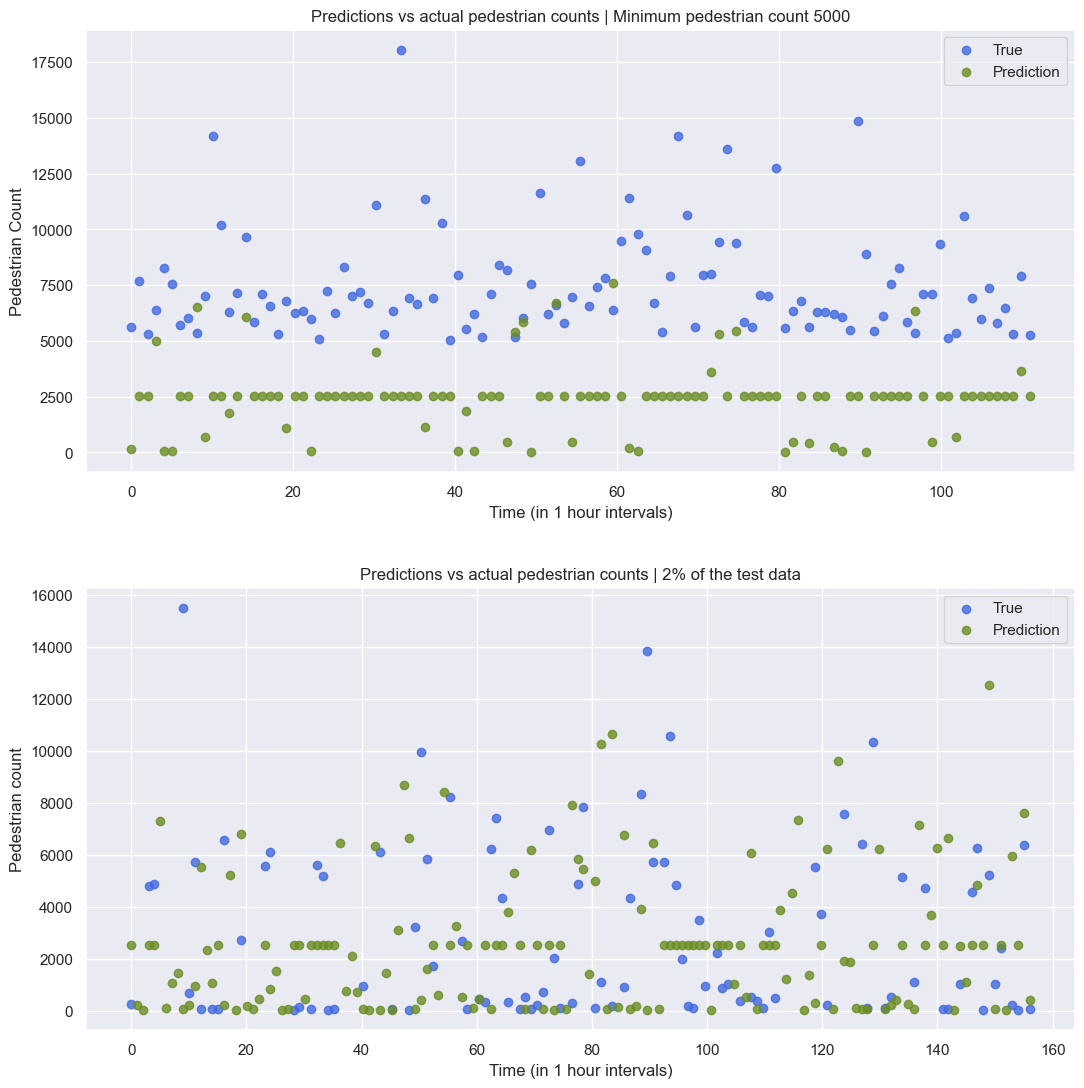

In [209]:
#Create a smaller Xtest to visualize the predictions and actual values better

Xtest_smaller1, ytest_smaller1 = Xtest_smaller(Xtest, ytest, percent=0.1, min_ped=5000)
Xtest_smaller2, ytest_smaller2 = Xtest_smaller(Xtest, ytest, percent=0.02, min_ped=0)

#Visualize the results predictions vs actual values
#Create a sequenze from 0 to the row lenght of the smaller test data in order to plot
xs1 = np.linspace(0, ytest_smaller1.shape[0], num=ytest_smaller1.shape[0])
xs2 = np.linspace(0, ytest_smaller2.shape[0], num=ytest_smaller2.shape[0])

#Using the Neural Network to predict the Pedestrian count for our Xtest set in order to plot it against the actual values
yhpred_smaller1 = h2_model.predict(Xtest_smaller1) #Predict the pedestrian count with the final Hypertuned model
yhpred_smaller2 = h2_model.predict(Xtest_smaller2) #Predict the pedestrian count with the final Hypertuned model

fig, axs = plt.subplots(2, figsize=(12, 12))

fig.tight_layout(pad=5.0)

axs[0].scatter(xs1, ytest_smaller1, color ='royalblue', alpha=0.8, label="True")
axs[0].scatter(xs1, yhpred_smaller1, color ='olivedrab', alpha=0.8, label="Prediction")
axs[0].set_title('Predictions vs actual pedestrian counts | Minimum pedestrian count 5000')
axs[0].set_ylabel('Pedestrian Count')
axs[0].set_xlabel('Time (in 1 hour intervals)')
axs[0].legend(loc='upper right')

axs[1].scatter(xs2, ytest_smaller2, color ='royalblue', alpha=0.8, label="True")
axs[1].scatter(xs2, yhpred_smaller2, color ='olivedrab', alpha=0.8, label="Prediction")
axs[1].set_title('Predictions vs actual pedestrian counts | 2% of the test data')
axs[1].set_ylabel('Pedestrian count')
axs[1].set_xlabel('Time (in 1 hour intervals)')
axs[1].legend(loc='upper right')


#### Visualize the predictions in comparisson with actual values 

#### This is with all data

In [210]:
split = [200, 500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000, 19000]
lower = 0
seperate_parts = []
for uper in split:
    part = df.loc[(df["pedestrians count"] >= lower) & (df["pedestrians count"] < uper)]
    lower = uper
    seperate_parts.append(part)

#### This is with all data

In [211]:
Xtest_new = Xtest.reset_index(drop=True)
ytest_new = ytest.reset_index(drop=True)

In [212]:
split = [200, 500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000, 19000]
lower = 0
seperate_parts_y = []
seperate_parts_x = []

for uper in split:
    y_part = ytest_new[(ytest_new >= lower) & (ytest_new < uper)]
    index_for_x = y_part.index[0:len(y_part)]
    x_part = Xtest_new.loc[index_for_x,]
    lower = uper
    seperate_parts_y.append(y_part)
    seperate_parts_x.append(x_part)

In [213]:
x_graph = np.linspace(0, len(y_graph), num=len(y_graph))
np.count_nonzero(~np.isnan(x_graph))
x_graph.max()

6.0

2022-12-01 20:11:56.555319: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 93ms/step


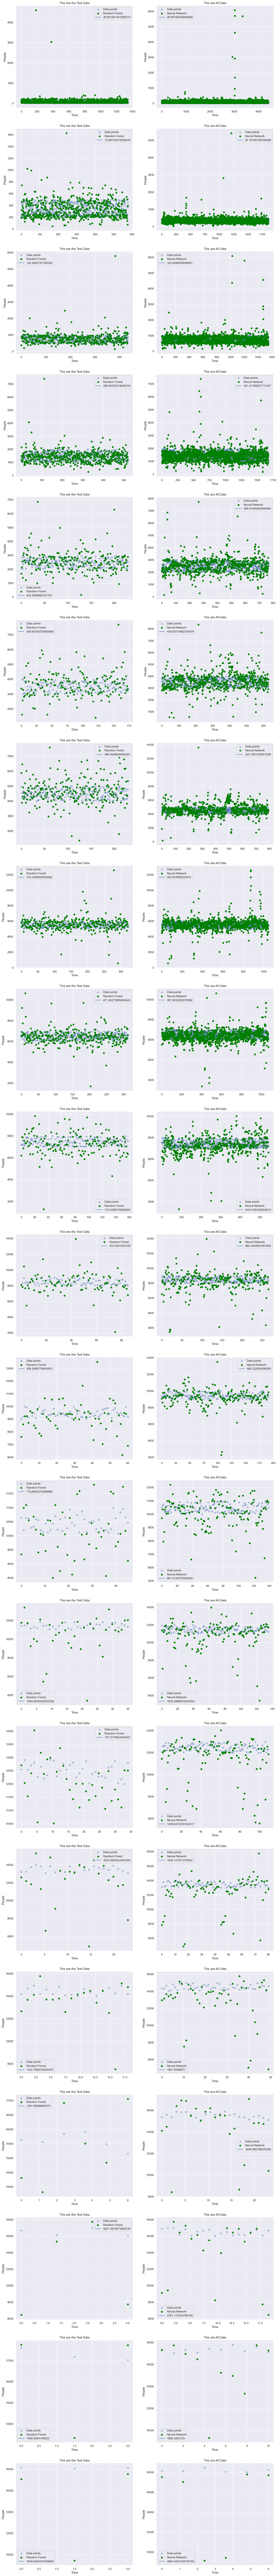

In [214]:
from sklearn.metrics import mean_absolute_error
# Set up the canvas
fig, axs = plt.subplots(len(seperate_parts),2,figsize=(18, 180))
# Make a scatterplot with temperature on the x-axis and number of rentals on the y axis

#################################################
#THIS IS FOR TEST ONLY
#################################################
for i in range(len(seperate_parts_y)):
    X_calc = seperate_parts_x[i] #[seperate_parts_x[i].columns[57:103]]
    # Output to predict
    y_graph = seperate_parts_y[i]#["pedestrians count"]

    x_graph = np.linspace(0, len(y_graph), num=len(y_graph))

    y_pred_graph = h2_model.predict(X_calc)

    axs[i][0].scatter(x_graph, y_graph, alpha=0.4, label="Data points")
    axs[i][0].scatter(x_graph, y_pred_graph, label="Random Forest", color="green", lw=1)
    axs[i][0].plot([], [], "" ,label=f"{mean_absolute_error(y_graph, y_pred_graph)}")


# Add the predictions of our model using a scatter plot
# Add labels on the axes, a legend, and a grid
for i in range(len(seperate_parts)):
    axs[i][0].legend()
    axs[i][0].set_xlabel("Time")
    axs[i][0].set_ylabel("People")
    axs[i][0].set_title("This are the Test Data")

#################################################
# THIS IS FOR ALL
#################################################
for i in range(len(seperate_parts)):
    X_calc = seperate_parts[i][seperate_parts[i].columns[57:103]]
    # Output to predict
    y_graph = seperate_parts[i]["pedestrians count"]

    x_graph = np.linspace(0, len(y_graph), num=len(y_graph))

    y_pred_graph = h2_model.predict(X_calc)

    axs[i][1].scatter(x_graph, y_graph, alpha=0.4, label="Data points")
    axs[i][1].scatter(x_graph, y_pred_graph, label="Neural Network", color="green", lw=1)
    axs[i][1].plot([], [], "" ,label=f"{mean_absolute_error(y_graph, y_pred_graph)}")


# Add the predictions of our model using a scatter plot
# Add labels on the axes, a legend, and a grid
for i in range(len(seperate_parts)):
    axs[i][1].legend()
    axs[i][1].set_xlabel("Time")
    axs[i][1].set_ylabel("People")
    axs[i][1].set_title("This are All Data")

#### Visualize all Models

144/144 [==============================] - 1s 5ms/step - loss: 295.4812 - mae: 295.4812


Text(109.87499999999999, 0.5, 'MAE')

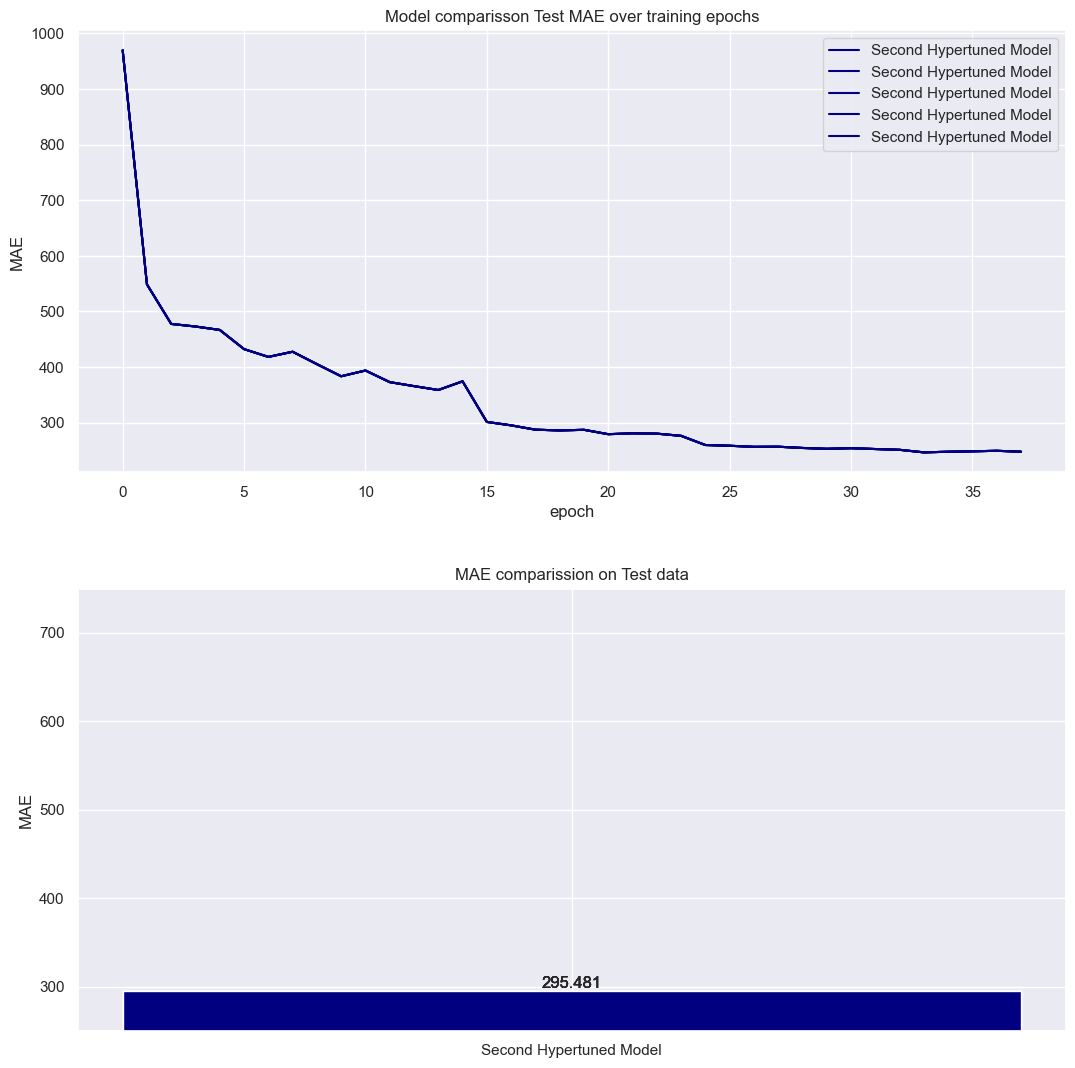

In [215]:
#Plot the MAE on the training data against the validation split of the Training data over time 
#history.history.keys()

fig, axs = plt.subplots(2, figsize=(12, 12))

fig.tight_layout(pad=5.0)

axs[0].plot(h2_history.history['mae'], label="Second Hypertuned Model", color="Navy")#Other Test MAE History - Change
axs[0].plot(h2_history.history['mae'], label="Second Hypertuned Model", color="Navy")#Other Test MAE History - Change
axs[0].plot(h2_history.history['mae'], label="Second Hypertuned Model", color="Navy")#Other Test MAE History - Change
axs[0].plot(h2_history.history['mae'], label="Second Hypertuned Model", color="Navy")#Other Test MAE History - Change
axs[0].plot(h2_history.history['mae'], label="Second Hypertuned Model", color="Navy")
axs[0].set_title('Model comparisson Test MAE over training epochs')
axs[0].set_ylabel('MAE')
axs[0].set_xlabel('epoch')
axs[0].legend(loc='upper right')


#Evalutaion on the Test Data 
hp2_mae = h2_model.evaluate(Xtest, ytest)#Other Test MAE - Change 
hp2_mae = h2_model.evaluate(Xtest, ytest)#Other Test MAE - Change
hp2_mae = h2_model.evaluate(Xtest, ytest)#Other Test MAE - Change
hp2_mae = h2_model.evaluate(Xtest, ytest)#Other Test MAE - Change
hp2_mae = h2_model.evaluate(Xtest, ytest)


axs[1].bar("Second Hypertuned Model", hp2_mae[0], color="navy")#Change
axs[1].bar("Second Hypertuned Model", hp2_mae[0], color="navy")#Change
axs[1].bar("Second Hypertuned Model", hp2_mae[0], color="navy")#Change
axs[1].bar("Second Hypertuned Model", hp2_mae[0], color="navy")#Change
axs[1].bar("Second Hypertuned Model", hp2_mae[0], color="navy")#Change

axs[1].bar_label(axs[1].containers[0], label_type='edge')
axs[1].bar_label(axs[1].containers[1], label_type='edge')
axs[1].bar_label(axs[1].containers[2], label_type='edge')
axs[1].bar_label(axs[1].containers[2], label_type='edge')
axs[1].bar_label(axs[1].containers[2], label_type='edge')

axs[1].set_ylim([250, 750])
axs[1].set_title('MAE comparission on Test data')
axs[1].set_ylabel('MAE')